# Exploratory Data Analysis

In this notebook the graphs corresponding to a first phase of identification prior to modeling are elaborated. The context of the COVID-19 epidemic in Spain is related to the data collected in order to better understand its dynamics.

The objective of this preliminary analysis is to identify characteristic patterns of the time series, such as trend, seasonal patterns, discontinuities in the data or outliers. It should also be concluded whether the data need any transformation or processing.

# Setup

In [1]:
# data handling
import pandas as pd
import numpy as np

# visualizations
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('seaborn-whitegrid')
import plotly.io as pio
pio.templates.default = "plotly_white"
from  datetime import timedelta
from random import randint
plt.rcParams['savefig.dpi'] = 1000

# path handling
from pathlib import Path
import os

# filter warnings
import warnings
warnings.filterwarnings("ignore")


ImportError: No module named plotly.express

# Data

Read saved static data (csv file) of COVID-19 cases in Spain. More info in https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos. 

For the comparative analysis of models, data is grouped to study national COVID-19 cases. Therefore, the curve of most interest in this study is the infected one. 

## Raw data

Raw data is the data imported directly from source and summed to get infected series. A sample of original raw data is shown too.

In [ ]:
# name of the file
file_name = 'spanish-covid-19-data-renave-07Jul2022.csv'

# data path
base_dir = Path(os.getcwd()).parents[0]

# path to read raw data
path_to_read_raw_data = base_dir / 'data' / 'raw-data' / file_name

# read data and show the first samples
df_raw = pd.read_csv(path_to_read_raw_data, parse_dates=['fecha'])
# rename columns
df_raw.rename(columns={'num_casos':'Infected', 'num_def': 'Deaths', 'fecha':'Date'}, inplace=True)
df_raw['Date'] = df_raw['Date'].apply(pd.Timestamp)

# group data to get total spanish cases
df_raw = df_raw.groupby(['Date']).sum()
df_raw = df_raw.asfreq('D') # daily data
df_raw = df_raw[(df_raw.index < pd.to_datetime('2021-12-01'))]
# select only inmportant columns
df_raw = df_raw[['Infected']]

# show sample of infected series
df_raw[pd.to_datetime('2021-07-20'):pd.to_datetime('2021-07-25')].head()

,Infected
Date,
2021-07-20,31881
2021-07-21,31921
2021-07-22,31106
2021-07-23,30243
2021-07-24,18228


In [ ]:
# sample of original raw data
pd.read_csv(path_to_read_raw_data, parse_dates=['fecha'])[900000:900005]

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def
900000,AL,H,0-9,2021-07-20,21,0,0,0
900001,AL,H,10-19,2021-07-20,42,0,0,0
900002,AL,H,20-29,2021-07-20,60,1,0,0
900003,AL,H,30-39,2021-07-20,25,0,0,1
900004,AL,H,40-49,2021-07-20,11,3,0,0


## Processed data

Processed data (with file data-retrieval.ipynb) with the following steps:
- Remove variables of hospitalized individuals and ICU inpatients (not relevant for analysis)
- Rename columns for ease of analysis
- Add population (total population of Spain as constant) for SIR study (population=susceptible)
- Smooth data by a mean average of 7 periods (days) to remove seasonal fluctuations caused by absence of data during weekends
- Add recovered variable by considering as recovering period 10 days from the beginning of the infected period 

In [ ]:
# name of the file
file_name = 'spanish-covid-19-data-renave-07Jul2022.csv'

# data path
base_dir = Path(os.getcwd()).parents[0]

# path to read final data
path_to_read_final_data = base_dir / 'data' / 'final-data' / file_name

# read data and show the first samples
df = pd.read_csv(path_to_read_final_data, parse_dates=['Date'])
df.set_index(['Date'], inplace=True)
df.head()

,Population,Infected,Deaths,Recovered
Date,,,,
2020-03-02,46796540,26.0,0.0,0.0
2020-03-03,46796540,38.0,0.0,0.0
2020-03-04,46796540,51.0,0.0,0.0
2020-03-05,46796540,75.0,0.0,0.0
2020-03-06,46796540,110.0,1.0,1.0


## Cumulative incidence data

Instead of considering the raw daily data, some studies consider the cumulative incidence of last 14 days per 100000 population. 

In [ ]:
def get_cumulative_incidence_data(days=14, cumsum=True):
    """
    Get the cumulative incidence data from infected in df
    Cumulative Incidence is computed by dividing total new cases in the period
    by the total susceptible cases at the begining of the period
    """
    df_cumulative_incidence = df[['Infected']].copy()
    period = f'{days}D'

    df_cumulative_incidence = df_cumulative_incidence.resample(period).sum()
    # df_cumulative_incidence = df_cumulative_incidence / 100000
    
    if cumsum: # returns cumulative incidence
        df_cumulative_incidence = df_cumulative_incidence.cumsum()
    return df_cumulative_incidence

In [ ]:
ci = get_cumulative_incidence_data(14, True)
ci.head()

,Infected
Date,
2020-03-02,6824.0
2020-03-16,85087.0
2020-03-30,172520.0
2020-04-13,214492.0
2020-04-27,231352.0


In [ ]:
# All infected series
I = {'raw':df_raw['Infected'].values, 'processed':df['Infected'].values, 'ci': ci.values}

# Time plot

The first step in a time series analysis is to plot the observations over time. The resulting graph should show key features of the time series data such as trend, seasonality, outliers and discontinuities. This preliminary graphical analysis is useful for describing the data and choosing an appropriate model.

The first series to be represented is the **raw infected data**. 

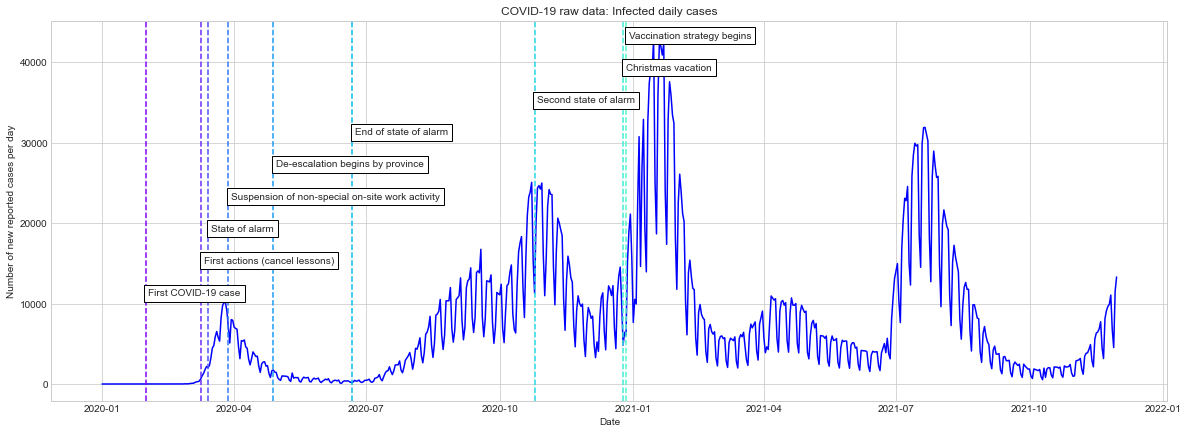

In [ ]:
# define significant dates
significant_events = {
    pd.Timestamp('2020-01-31'): 'First COVID-19 case',
    # pd.Timestamp('2020-02-13'): 'First official death with COVID-19',
    # pd.Timestamp('2020-03-08'): 'Protests',
    pd.Timestamp('2020-03-09'): 'First actions (cancel lessons)',
    # pd.Timestamp('2020-03-10'): 'Cancellations of flights and mass events',
    pd.Timestamp('2020-03-14'): 'State of alarm',
    pd.Timestamp('2020-03-28'): 'Suspension of non-special on-site work activity',
    # pd.Timestamp('2020-04-02'): 'Highest number of deaths in one day',
    pd.Timestamp('2020-04-28'): 'De-escalation begins by province',
    pd.Timestamp('2020-06-21'): 'End of state of alarm',
    pd.Timestamp('2020-10-25'): 'Second state of alarm',
    # pd.Timestamp('2020-09-15'): 'Día de la Hispanidad',
    # pd.Timestamp('2020-10-12'): 'Día de la Hispanidad',
    pd.Timestamp('2020-12-25'): 'Christmas vacation',
    pd.Timestamp('2020-12-27'): 'Vaccination strategy begins',
    # pd.Timestamp('2021-10-12'): 'Día de la Hispanidad',
    # pd.Timestamp('2021-12-25'): 'Christmas vacation',
}

# plot raw time series
fig = plt.figure(figsize=(20, 7))
color = iter(cm.rainbow(np.linspace(0, 1, 20)))

plt.plot(df_raw, color='b')

i = 10000

for significant_event, value in significant_events.items():
    text_index = 21000 - i
    plt.axvline(x=significant_event, color=next(
        color), linestyle='--', label=value)
    text = plt.text(significant_event+timedelta(2),text_index, value,fontsize=10)
    text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

    i -= 4000

# plt.legend()

plt.xlabel('Date')
plt.ylabel('Number of new reported cases per day')
plt.title('COVID-19 raw data: Infected daily cases')
plt.show()


Several observations can be drawn from the above graph. 

Firstly, it can be seen how the series starts on 01-01-2020, but the first values are zero. The virus was first confirmed to have spread to Spain on 31-01-2020.
The first non zero value in this data is recorded on day 09-01-2020, however more values equal to zero follow. 

Uncomment the cell below to get an interactive graph

In [ ]:
# fig = px.line(df_raw['Infected'], title='COVID-19 raw data: Infected daily cases')
# fig.update_layout(showlegend=False) # hide legend 
# fig.update_yaxes(title='Number of new reported cases per day')
# fig.show()

The cell below prints when the last zero value is: 2020-02-20. This zero set of values is irrelevant, so only data after this last date is considered for analysis.

In [ ]:
# set of dates where there are zero values
zero_infected_series_dates = df_raw['Infected'][df_raw['Infected']==0].index
print('Last index of zero infected series:', zero_infected_series_dates[-1])

# select data after that day
df_raw = df_raw[df_raw.index > pd.to_datetime('2020-02-20')]

Last index of zero infected series: 2020-02-20 00:00:00


# Seasonal patterns

Since the series contain a seasonal pattern, it must be stutied to determine if it is relevant or just noise.

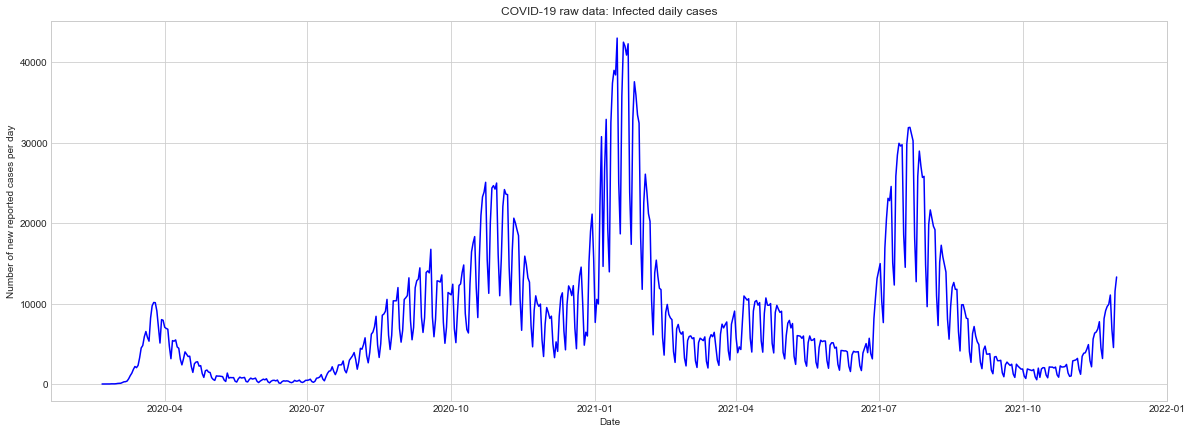

In [ ]:
fig = plt.figure(figsize=(20, 7))
plt.plot(df_raw, color = 'b')
plt.title('COVID-19 raw data: Infected daily cases')
plt.xlabel('Date')
plt.ylabel('Number of new reported cases per day')
plt.show()

1. The series clearly contains seasonal fluctuations with period 7: every 7 days (week) there are repeating peaks and troughs. This may be due to the lack of data communication from the communities on weekends.
2. These seasonal fluctuations become stronger in some time periods: the seasonal effect appears to increase with the mean. This can be examined by zooming the period October-2021 to April-2022.
3. There are outliers in summer (July) and in the Christmas season (January). 

The first point confirms that a seasonal adjustement must be performed in the analysis and the second points suggests that the pattern could be multiplicative. The outliers must be taken into account for the analysis.

A bar chart is now used to study whether the daily data are biased.  

For this purpose, two columns are added: one indicating the day of the week and the other indicating the number of the week of the year. Then, the series of infected for each day of the week (7 series) and the series of total infected per week are considered. Subsequently, each of the 7 series is divided by the total infected per week to obtain the percentage of cases per day of the week with respect to the reported totals. The mean of the new series obtained is calculated. As the sum of the means can be greater than one, the values are normalized. Finally, they are plotted.

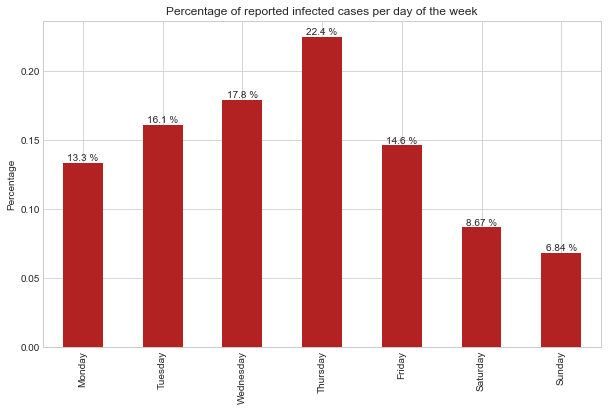

In [ ]:
# add column for day of week and number of week of the year
df_raw['day_of_week'] = df_raw.index.day_name()
df_raw['number_of_week'] = df_raw.index.week

# sum 53 to each number of week of year 2021
df_raw['number_of_week'][df_raw.index>pd.to_datetime('2021-01-03')] = df_raw['number_of_week'][df_raw.index>pd.to_datetime('2021-01-03')] + 53

# select series of infected for each day of the week
infected_per_day_of_week = {}
for day_of_week in df_raw['day_of_week'].unique():
    infected_per_day_of_week[day_of_week] = df_raw[df_raw['day_of_week']==day_of_week]['Infected'].values

# get total infected cases per number of week
infected_per_week = df_raw.groupby('number_of_week')['Infected'].sum()

# get min length between values of infected_per_day_of_week
min_length = min([len(infected_per_day_of_week[day_of_week]) for day_of_week in infected_per_day_of_week])

# divide each value of infected_per_day_of_week by the infected_per_week
percentage_infected_per_day = {}
for day_of_week in infected_per_day_of_week:
    percentage_infected_per_day[day_of_week] = (infected_per_day_of_week[day_of_week][:min_length] / infected_per_week.values[:min_length]).mean()

# define order
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# sort dict by key by above order
percentage_infected_per_day = {key: percentage_infected_per_day[key] for key in order}

# normalize values so that they sum up to 1
percentage_infected_per_day_normalized = {key: percentage_infected_per_day[key]/sum(percentage_infected_per_day.values()) for key in order}

# plot
plt.figure(figsize=(10, 6))
ax = pd.Series(percentage_infected_per_day_normalized).plot(kind="bar", color='firebrick', legend=False)

rects = ax.patches

labels = [f'{str(value*100)[:4]} %' for value in percentage_infected_per_day_normalized.values()]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, rect.get_height(), label, ha="center", va="bottom"
    )

plt.title("Percentage of reported infected cases per day of the week")
plt.ylabel("Percentage")
plt.show()

The days with the fewest reported cases are Sunday and Saturday; the days with the most reported cases are Thursday and Wednesday. This does not respond to a pattern of behavior of the spread of the virus. It is therefore concluded that it is the result of the structure of the work week and not an inherent characteristic of the phenomenon.

In [4]:
from outliers import smirnov_grubbs as grubbs

ImportError: No module named outliers

In [3]:
!pip install outliers_utils

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  ERROR: Could not find a version that satisfies the requirement outliers_utils (from versions: none)
ERROR: No matching distribution found for outliers_utils
